공유자전거 수요 예측
=================

예측 데이터로 공유 자전거를 선택한 이유
---
> 1. 자전거 공유 시스템은 회원 가입, 대여 및 자전거 반납 과정이 도시 전역의 키오스크 위치 네트워크를 통해 자동화되는 자전거 대여 수단입니다. 
> 2. 이 시스템을 사용하여 사람들은 한 장소에서 자전거를 빌렸고 필요에 따라 다른 장소로 반납할 수 있습니다. 현재 전 세계적으로 500개 이상의 자전거 공유 프로그램이 있습니다.
> 3. 이러한 시스템에서 생성된 데이터는 여행 기간, 출발 위치, 도착 위치 및 경과 시간이 명시적으로 기록되기 때문에 연구자에게 매력적입니다. 
> 4. 따라서 자전거 공유 시스템은 도시에서 이동성을 연구하는 데 사용할 수 있는 센서 네트워크의 기능을 합니다. 
> 5. 워싱턴 DC의 Capital Bikeshare 프로그램에서 자전거 대여 수요를 예측하기 위해 날씨 데이터와 과거 사용 패턴을 결합해야 합니다.
>> 한국의 공유 자전거 데이터는 불필요한 데이터가 너무 많아 전처리를 많이 해야 하거나,  데이터 제공을 하지 않아 불가피 하게 외국 데이터로 진행 하였음

데이터 특징
---
- 2년의 시간당 공유 자전거 데이터가 제공됩니다. 훈련 세트는 매월 19일, 테스트 세트는 20일부터 말일까지 입니다. 테스트 세트가 적용되는 각 시간 동안 대여한 자전거의 총 수를 대여 기간 이전에 사용할 수 있는 정보만 사용하여 예측해야 합니다.

데이터 필드 설명
---
datetime - 시간별 날짜 + 타임스탬프   
season - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울      
holiday - 그 날이 휴일로 간주되는지 여부   
workingday - 그 날이 주말도 휴일도 아닌 근무일인지 여부   
weather   
        - 1: 맑음, 거의 없음 구름, 약간 흐림, 약간 흐림   
        - 2: 안개 + 흐림, 안개 + 부서진 구름, 안개 + 약간 구름, 안개   
        - 3: 약한 눈, 약한 비 + 뇌우 + 산발적 구름, 가벼운 비 + 산발적인 구름   
        - 4: 큰 비 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개     
temp - 섭씨 온도   
atemp - "체감" 온도(섭씨)   
humidity - 상대 습도   
windspeed - 풍속   
casual - 등록 된 미등록 사용자 렌탈 횟수    
registered - 등록 된 사용자 렌탈 시작   
count - 총 렌탈 횟수

#### 출처

* HadiFanaee Tork: https://ride.capitalbikeshare.com/system-data
* kaggle: https://www.kaggle.com/competitions/bike-sharing-demand/overview

## Load Dataset

In [25]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#노트북 안에 그래프를 그리기 위해
%matplotlib inline
#그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("data/bike-sharing-demand/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("data/bike-sharing-demand/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

## Feature Engineering

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [5]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 16)

<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

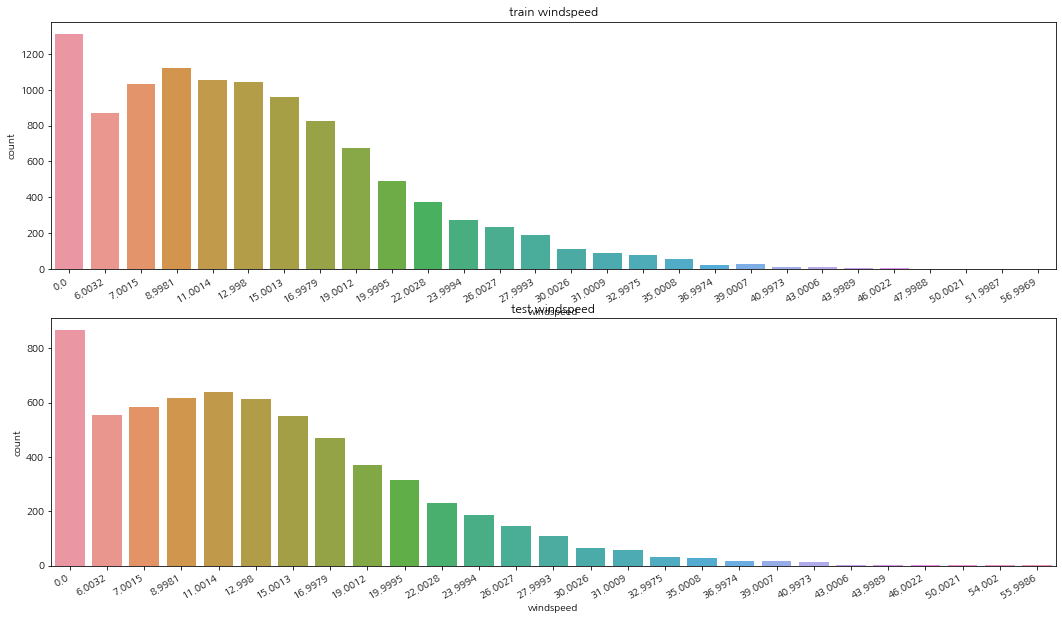

In [6]:
# windspeed 풍속에 0 값이 가장 많다. ==> 잘못 기록된 데이터를 고쳐 줄 필요가 있음.
# 데이터가 0 일수도 있지만, 데이터가 입력되지 않아서 0으로 표기 되었을 수도 있기에 잘못된 데이터는 예측 값으로 넣어줄 수 밖에 없음.
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed',ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30,ha='right')
axes[1].set(ylabel='Count', title='test windspeed')
sns.countplot(data=test, x='windspeed', ax=axes[1])

In [7]:
# 풍속의 0값에 특정 값을 넣어준다.
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
# train.loc[train['windspeed'] == 0 , 'windspeed'] = train['windspeed'].mean()
# test.loc[test['windspeed'] == 0 , 'windspeed'] = test['windspeed'].mean()

In [8]:
#풍속이 0인것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0)
print(trainWindNot0)

                 datetime  season  holiday  workingday  weather   temp  \
0     2011-01-01 00:00:00       1        0           0        1   9.84   
1     2011-01-01 01:00:00       1        0           0        1   9.02   
2     2011-01-01 02:00:00       1        0           0        1   9.02   
3     2011-01-01 03:00:00       1        0           0        1   9.84   
4     2011-01-01 04:00:00       1        0           0        1   9.84   
...                   ...     ...      ...         ...      ...    ...   
10826 2012-12-17 12:00:00       4        0           1        2  16.40   
10829 2012-12-17 15:00:00       4        0           1        2  17.22   
10846 2012-12-18 08:00:00       4        0           1        1  15.58   
10860 2012-12-18 22:00:00       4        0           1        1  13.94   
10862 2012-12-19 00:00:00       4        0           1        1  12.30   

        atemp  humidity  windspeed  casual  registered  count  year  month  \
0      14.395        81        0.

In [9]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']
    
    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')
    
    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()
    
    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    
    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])
    
    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0['windspeed'] = wind0Values
    
    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레인을 합쳐준다.
    data = predictWindNot0.append(predictWind0)
    
    # 풍속의 데이터타입을 float으로 지정해 준다.
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True,axis =1)
    
    return data

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

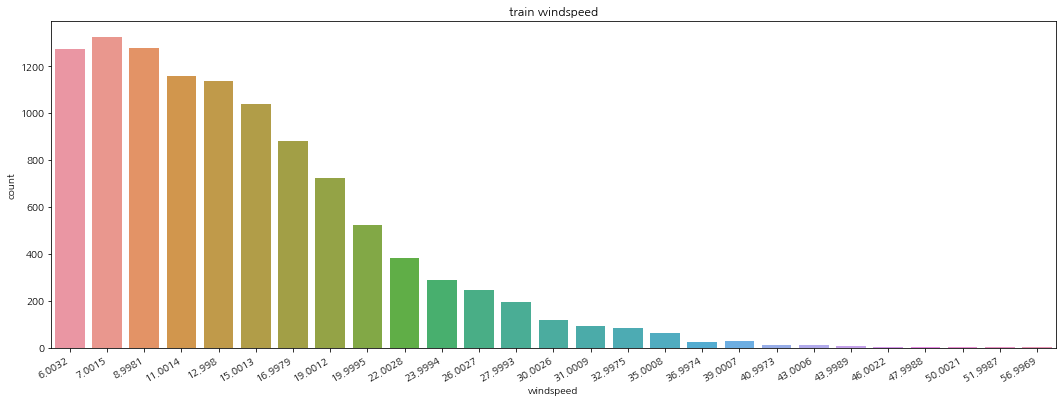

In [10]:
# 0값을 조정한다.
train= predict_windspeed(train)
#test = predict_windspeed(test)

# windspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

## Feature Selection
- 신호와 잡음을 구분해야 한다.
- 피처가 많다고 해서 무조건 좋은 성능을 내지는 않는다.
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [11]:
# 연속성 feature와 범주형 feature
# 연속성 feature = ['temp', 'humidity', 'windspeed', 'atemp']
# 범주형 featured의 type 을 category로 변경 해 준다.

categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 
                             'dayofweek', 'month', 'year', 'hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [12]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 
                             'year', 'hour', 'dayofweek','holiday', 'workingday']

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [13]:
X_train= train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [14]:
X_test= test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [15]:
label_name = 'count'

y_train=train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

## Score
## RMSLE
###### 과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.
###### 오차(error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root) 으로 값이 작을 수록 정밀도가 높다.
###### 0에 가까운 값이 나올 수록 정밀도가 높은 값이다.
###### Submissions are evaluated one the Root Mean SquaredLogarithmic Error(RMSLE)

In [22]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values): 
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다
    mean_difference = difference.mean()
    
    #다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## Cross Validation 교차 검증
- 일반화 성능을 측정하기 위해 데이터를 여러 번 반복하고 나누고 여러 모델을 학습한다.

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## RandomForest

In [61]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor (n_estimators=500, n_jobs= -1, random_state= 15)
model

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=15)

In [62]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()

# 지금 상황에서는 0에 근접할 수록 좋은 데이터
print('Score = {0:.5f}'.format(score))

Wall time: 1min 21s
Score = 0.32977


## Train

In [63]:
#학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각) - 피처와 레이블을 넣어주면 알아서 학습 한다.
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=15)

In [64]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 11.948 ,   5.124 ,   3.9115,   3.538 ,   3.036 ,   6.436 ,
        38.106 , 106.706 , 241.704 , 134.946 ])

[Text(0.5, 1.0, '예측')]

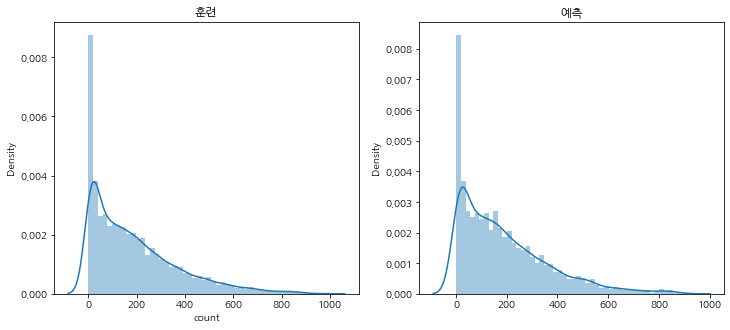

In [68]:
#데이터를 시각화 한다
fig,(ax1, ax2)=plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1, bins=50)
ax1.set(title="훈련")
sns.distplot(predictions,ax=ax2, bins=50)
ax2.set(title='예측')

## SubMit

In [67]:
submission = pd.read_csv("data/bike-sharing-demand/sampleSubmission.csv")
submission

submission['count'] = predictions
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.9480
1,2011-01-20 01:00:00,5.1240
2,2011-01-20 02:00:00,3.9115
3,2011-01-20 03:00:00,3.5380
4,2011-01-20 04:00:00,3.0360
